## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.

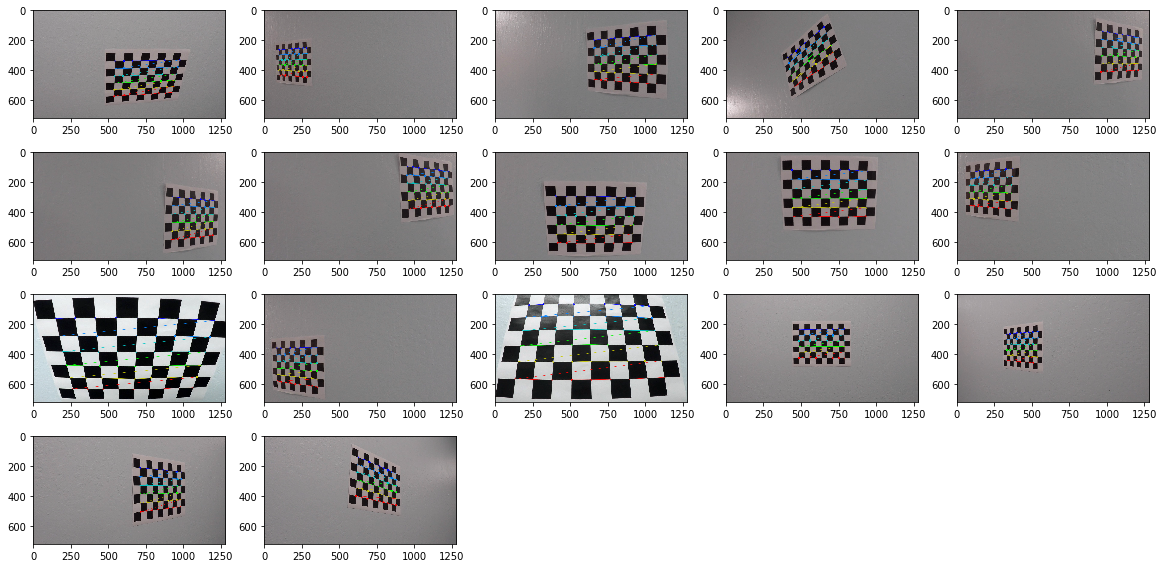

In [420]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import os
#%matplotlib qt

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
file_path = os.getcwd()
file_path = file_path + '/camera_cal/calibration*.jpg'
images = glob.glob(file_path)

plt.figure(figsize=(20,10))
# Step through the list and search for chessboard corners
i=1
for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)
    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
        #cv2.imshow('img',img)
        #cv2.waitKey(500)
        plt.subplot(4,5,i)
        plt.imshow(img)        
        i=i+1
plt.show()

#cv2.destroyAllWindows()

## Apply a distortion correction to raw images.


In [421]:
def undistort_image(img, mtx, dist):
    dst = cv2.undistort(img, mtx, dist, None, mtx)
    return dst

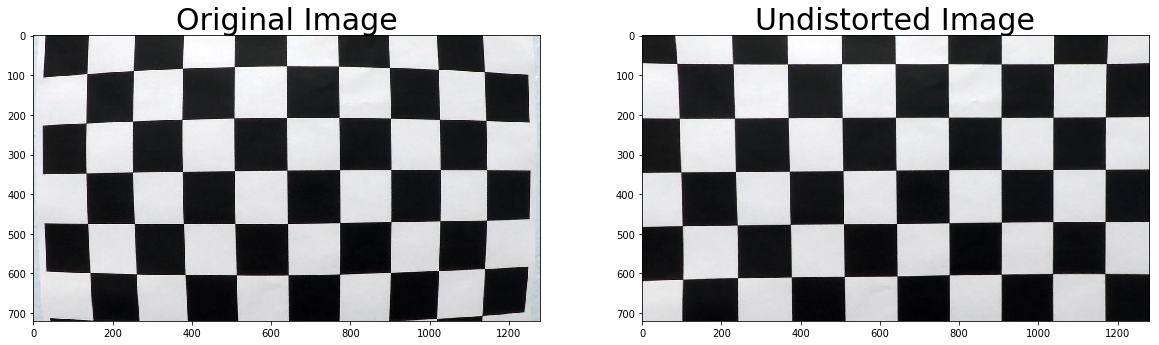

In [422]:
import pickle
%matplotlib inline

# Test undistortion on an image
file_path = os.getcwd()
file_path = file_path + '/camera_cal/calibration1.jpg'
img = cv2.imread(file_path)
img_size = (img.shape[1], img.shape[0])

# Do camera calibration given object points and image points
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)

file_path = os.getcwd()
file_path = file_path + '/output_images/calibration1_undist.jpg'
dst = cv2.undistort(img, mtx, dist, None, mtx)
cv2.imwrite(file_path,dst)

# Save the camera calibration result for later use (we won't worry about rvecs / tvecs)
dist_pickle = {}
dist_pickle["mtx"] = mtx
dist_pickle["dist"] = dist
pickle.dump( dist_pickle, open( "calibration_results.p", "wb" ) )
#dst = cv2.cvtColor(dst, cv2.COLOR_BGR2RGB)
# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(dst)
ax2.set_title('Undistorted Image', fontsize=30)

## Use color transforms, gradients, etc., to create a thresholded binary image.

In [499]:
def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    # Apply the following steps to img
    # 1) Convert to grayscale
    #gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    #l_channel = cv2.equalizeHist(l_channel)
    #s_channel = cv2.equalizeHist(s_channel)
    
    # 2) Take the gradient in x and y separately
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0)
    sobely = cv2.Sobel(l_channel, cv2.CV_64F, 0, 1)
    # 3) Calculate the magnitude 
    abs_sobelxy = np.sqrt(sobelx**2+sobely**2)
    # 4) Scale to 8-bit (0 - 255) and convert to type = np.uint8
    scaled_sobel = np.uint8(255*abs_sobelxy/np.max(abs_sobelxy))
    # 5) Create a binary mask where mag thresholds are met
    binary_output_l = np.zeros_like(scaled_sobel)
    binary_output_l[(scaled_sobel >= mag_thresh[0]) & (scaled_sobel <= mag_thresh[1])] = 1

    # 2) Take the gradient in x and y separately
    sobelx = cv2.Sobel(s_channel, cv2.CV_64F, 1, 0)
    sobely = cv2.Sobel(s_channel, cv2.CV_64F, 0, 1)
    # 3) Calculate the magnitude 
    abs_sobelxy = np.sqrt(sobelx**2+sobely**2)
    # 4) Scale to 8-bit (0 - 255) and convert to type = np.uint8
    scaled_sobel = np.uint8(255*abs_sobelxy/np.max(abs_sobelxy))
    # 5) Create a binary mask where mag thresholds are met
    binary_output_s = np.zeros_like(scaled_sobel)
    binary_output_s[(scaled_sobel >= mag_thresh[0]) & (scaled_sobel <= mag_thresh[1])] = 1    
    
    binary_output = cv2.bitwise_or(binary_output_l,binary_output_s)
    
    return binary_output

In [500]:
def abs_sobel_thresh(img, orient='x', thresh_min=0, thresh_max=255):

    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    l_channel = cv2.equalizeHist(l_channel)
    s_channel = cv2.equalizeHist(s_channel)
    #l_channel = cv2.GaussianBlur(l_channel, (9, 9), 0)
    #s_channel = cv2.GaussianBlur(s_channel, (9, 9), 0)
    
    # 2) Take the derivative in x or y given orient = 'x' or 'y'
    if orient == 'x':
        sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0)
        abs_sobel = np.absolute(sobelx)
    else:
        sobely = cv2.Sobel(l_channel, cv2.CV_64F, 0, 1)
        abs_sobel = np.absolute(sobely)
    # 4) Scale to 8-bit (0 - 255) then convert to type = np.uint8
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # 5) Create a mask of 1's where the scaled gradient magnitude 
    binary_output_l = np.zeros_like(scaled_sobel)
    binary_output_l[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1

    # 2) Take the derivative in x or y given orient = 'x' or 'y'
    if orient == 'x':
        sobelx = cv2.Sobel(s_channel, cv2.CV_64F, 1, 0)
        abs_sobel = np.absolute(sobelx)
    else:
        sobely = cv2.Sobel(s_channel, cv2.CV_64F, 0, 1)
        abs_sobel = np.absolute(sobely)
    # 4) Scale to 8-bit (0 - 255) then convert to type = np.uint8
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # 5) Create a mask of 1's where the scaled gradient magnitude 
    binary_output_s = np.zeros_like(scaled_sobel)
    binary_output_s[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1
    
    binary_output = cv2.bitwise_or(binary_output_l,binary_output_s)
    
    return binary_output

In [501]:
def S_threshold(img, s_thresh):
    # Convert to HLS color space and separate the V channel
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]
    #s_channel = cv2.equalizeHist(s_channel)

    # define range of blue color in 
    lower = np.array([15,100,100])
    upper = np.array([35,255,255])
    # Threshold the HSV image to get only blue colors
    s_binary_y = cv2.inRange(hls, lower, upper)
    
    # define range of blue color in 
    lower = np.array([0,200,0])
    upper = np.array([255,255,255])
    
    # Threshold the HSV image to get only blue colors
    s_binary_w = cv2.inRange(hls, lower, upper)
    s_binary = cv2.bitwise_or(s_binary_y,s_binary_w)

    return s_binary

In [502]:
def dir_threshold(img, sobel_kernel=3, abs_thres=(20), dir_thresh=(0, np.pi/2)):
    
    # Apply the following steps to img
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    #l_channel = cv2.equalizeHist(l_channel)
    #s_channel = cv2.equalizeHist(s_channel)

    # 2) Take the gradient in x and y separately
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(s_channel, cv2.CV_64F, 0, 1, ksize=sobel_kernel)

    # 3) Take the absolute value of the x and y gradients
    sobelx = np.absolute(sobelx)
    sobely = np.absolute(sobely)
    
    abs_sobel = np.absolute(sobelx)
    scaled_sobelx = np.uint8(255*abs_sobel/np.max(abs_sobel))
    abs_sobel = np.absolute(sobely)
    scaled_sobely = np.uint8(255*abs_sobel/np.max(abs_sobel))

    sobelx[(scaled_sobelx<abs_thres)] = 0
    sobely[(scaled_sobely<abs_thres)] = 0

    # 4) Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient 
    absgraddir = np.arctan2(sobely,sobelx)
    # 5) Create a binary mask where direction thresholds are met
    binary_output_l = np.zeros_like(absgraddir)
    binary_output_l[(absgraddir >= dir_thresh[0]) & (absgraddir <= dir_thresh[1])] = 1

    # 2) Take the gradient in x and y separately
    sobelx = cv2.Sobel(s_channel, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(s_channel, cv2.CV_64F, 0, 1, ksize=sobel_kernel)

    # 3) Take the absolute value of the x and y gradients
    sobelx = np.absolute(sobelx)
    sobely = np.absolute(sobely)
    
    abs_sobel = np.absolute(sobelx)
    scaled_sobelx = np.uint8(255*abs_sobel/np.max(abs_sobel))
    abs_sobel = np.absolute(sobely)
    scaled_sobely = np.uint8(255*abs_sobel/np.max(abs_sobel))

    sobelx[(scaled_sobelx<abs_thres)] = 0
    sobely[(scaled_sobely<abs_thres)] = 0

    # 4) Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient 
    absgraddir = np.arctan2(sobely,sobelx)
    # 5) Create a binary mask where direction thresholds are met
    binary_output_s = np.zeros_like(absgraddir)
    binary_output_s[(absgraddir >= dir_thresh[0]) & (absgraddir <= dir_thresh[1])] = 1
    
    binary_output = cv2.bitwise_or(binary_output_l,binary_output_s)
    
    return binary_output

In [503]:
def R_threshold(img, r_thresh):
    R = img[:,:,0]
    
    r_binary = np.zeros_like(R)
    r_binary[(R > r_thresh[0]) & (R <= r_thresh[1])] = 1
    
    return r_binary

In [506]:
# Edit this function to create your own pipeline.
def image_threshold(img):
    #img = np.copy(img)

    
    # Sobel x
    #sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    #abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    #scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    #sxbinary = np.zeros_like(scaled_sobel)
    #sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    

    # Stack each channel
    # Note color_binary[:, :, 0] is all 0s, effectively an all black image. It might
    # be beneficial to replace this channel with something else.
    # color_binary_stack = np.dstack(( 150*np.ones_like(sxbinary), sxbinary, s_binary))
    
    mag_binary = np.uint8(mag_thresh(img, sobel_kernel=3, mag_thresh=(50, 255))) #65
    #mag_binary = cv2.erode(mag_binary, np.ones((3, 3)))

    #sobelx_binary = np.uint8(abs_sobel_thresh(img, orient='x', thresh_min=35, thresh_max=255))
    #sobelx_binary = cv2.erode(sobelx_binary, np.ones((31, 31)))

    #sobely_binary = np.uint8(abs_sobel_thresh(img, orient='y', thresh_min=30, thresh_max=255))
    dir_binary = np.uint8(dir_threshold(img, sobel_kernel=15, abs_thres=(20), dir_thresh=(np.pi/2-1,np.pi/2-0.2)))
    #dir_binary = cv2.erode(dir_binary, np.ones((3, 3)))

    s_binary = np.uint8(S_threshold(img, s_thresh=(150, 255)))
    r_binary = np.uint8(R_threshold(img, r_thresh=(220, 255)))
    
    ch1_binary = cv2.bitwise_or(s_binary,r_binary)
    ch2_binary = mag_binary#cv2.bitwise_or(sobelx_binary,mag_binary)
    ch3_binary = (dir_binary)
    binary_stack = 255*np.dstack((ch1_binary, ch2_binary, ch3_binary))


    #color_binary_stack = np.array(255*color_binary_stack, dtype = np.float64)
    #s_binary = np.uint8(s_binary)
    #r_binary = np.uint8(r_binary)

    #color_binary = cv2.cvtColor(color_binary_stack,cv2.COLOR_GRAY2RGB)
    binary = np.zeros_like(s_binary)

    binary[(ch1_binary > 0) | (ch2_binary > 0) |(ch3_binary > 0)] = 255
    #binary[(ch1_binary > 0) | (ch1_binary > 0) |(ch1_binary > 0)] = 255

    #color_binary = (binary_stack)
    #binary_stack = np.dstack((binary, binary, binary))
    binary = cv2.erode(binary, np.ones((3, 3)))

    return binary,binary_stack

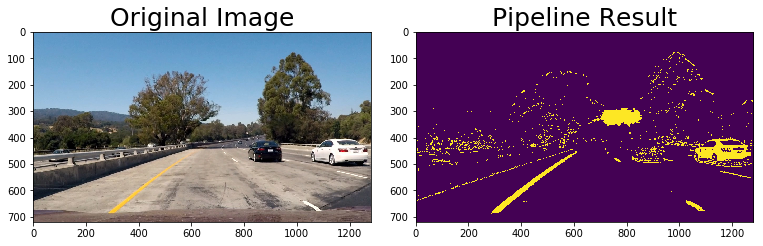

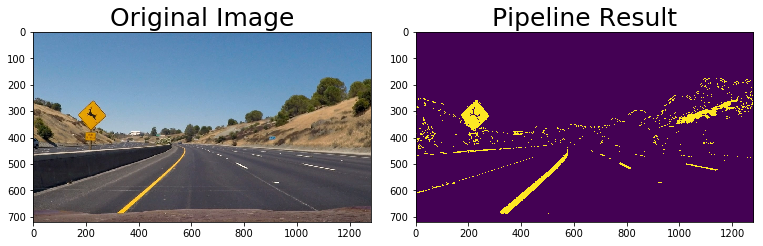

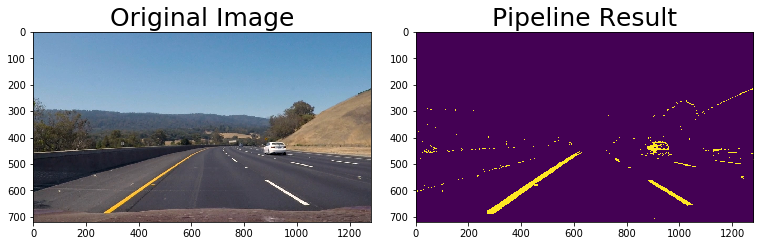

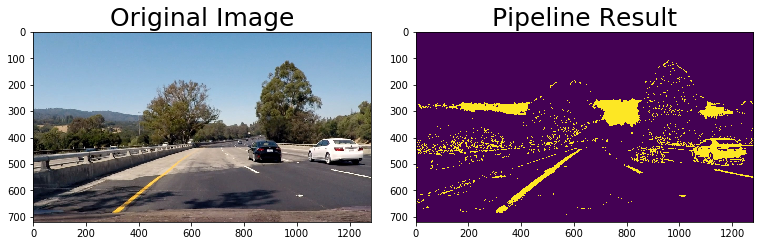

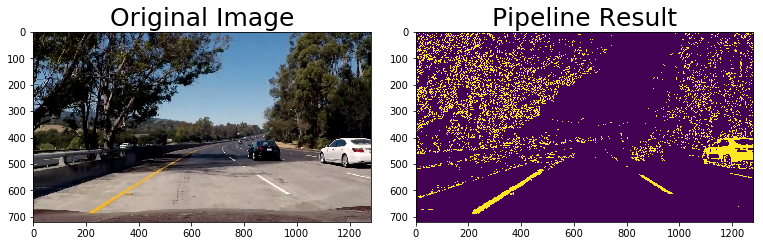

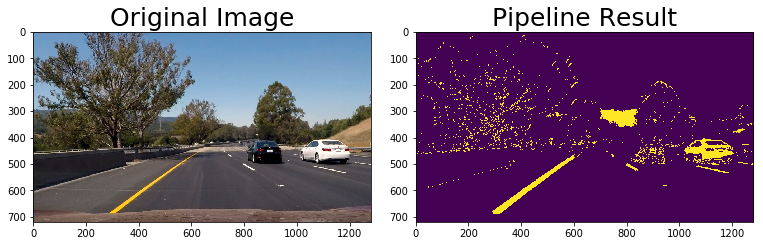

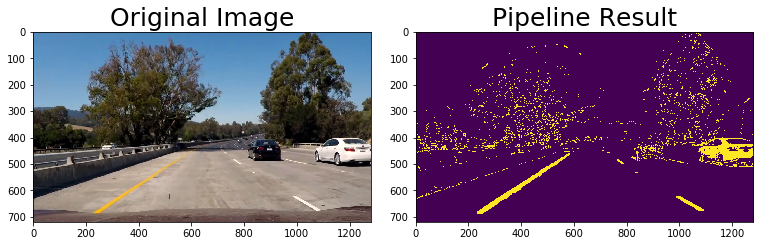

In [507]:
import matplotlib.image as mpimg
# Make a list of test images
file_path = os.getcwd()
file_path = file_path + '/test_images/test*.jpg'
images = glob.glob(file_path) 

i=0
for fname in images:    
    image = mpimg.imread(fname)
    res,result = image_threshold(image)
    
    i=i+1
    file_path = os.getcwd()
    file_path = file_path + '/output_images/' + 'binary' + str(i) + '.jpg'
    cv2.imwrite(file_path,res)

    # Plot the result
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
    f.tight_layout()

    ax1.imshow(image)
    ax1.set_title('Original Image', fontsize=25)

    ax2.imshow(res)
    ax2.set_title('Pipeline Result', fontsize=25)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
    plt.show()


## Apply a perspective transform to rectify binary image ("birds-eye view").

In [508]:
def image_unwarp(img):
    # d) use cv2.getPerspectiveTransform() to get M, the transform matrix
    
    # 4 destination points dst = np.float32([[,],[,],[,],[,]])
    src = np.float32([[580,450],[770,450],[1130,680],[220,680]])
    src = np.float32([[580,450],[770,450],[1320,680],[30,680]])
    src = np.float32([[650-70,450],[650+70,450],[650+600,680],[650-600,680]])
    src = np.float32([[590,450],[700,450],[1133,680],[200,680]])

    #print(src)

    offset = 200 # offset for dst points
    dst = np.float32([[offset, offset], [img_size[0]-offset, offset], 
                      [img_size[0]-offset, img_size[1]], 
                      [offset, img_size[1]]])
    dst = np.float32([[offset, 0], [img_size[0]-offset, 0], 
                      [img_size[0]-offset, img_size[1]], 
                      [offset, img_size[1]]])

    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)

    # e) use cv2.warpPerspective() to warp your image to a top-down view
    warped = cv2.warpPerspective(img, M, (img.shape[1], img.shape[0]))
    #warped = cv2.erode(warped, np.ones((3, 3)))

    return warped,Minv


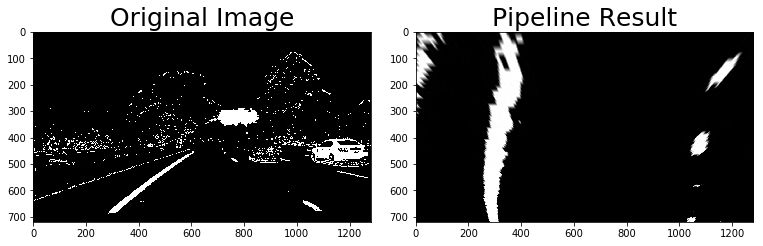

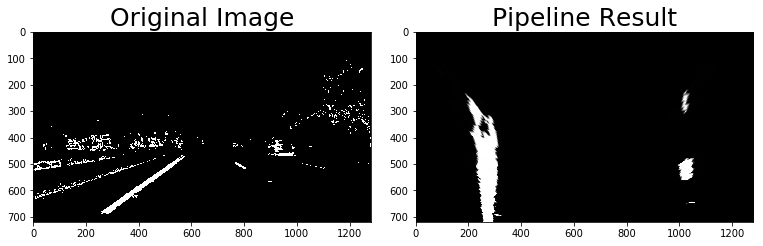

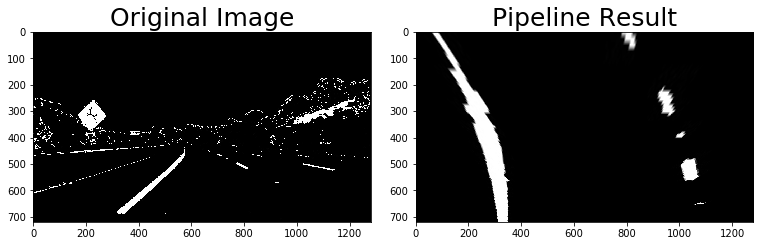

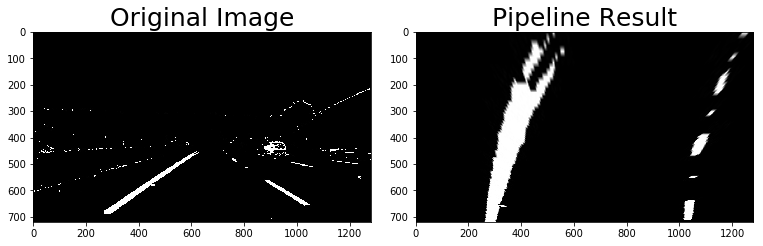

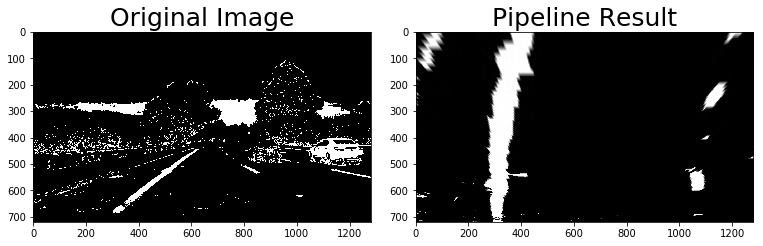

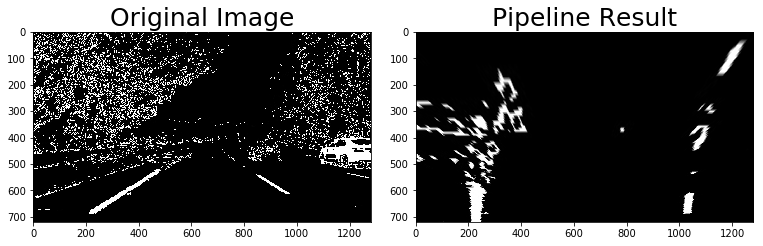

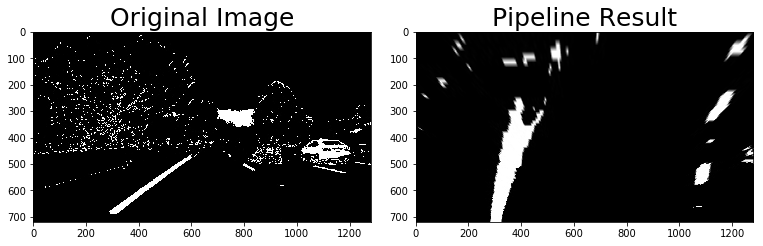

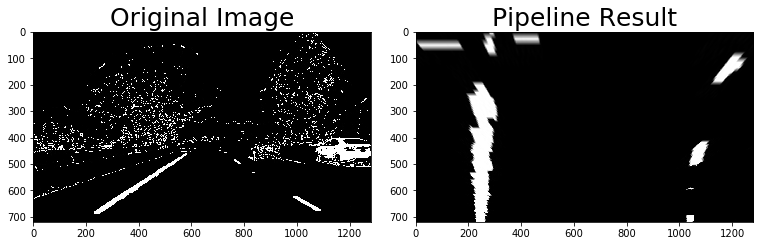

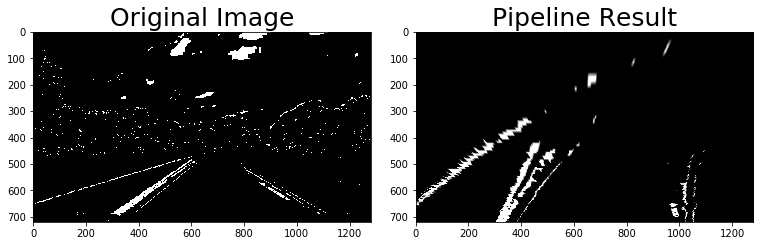

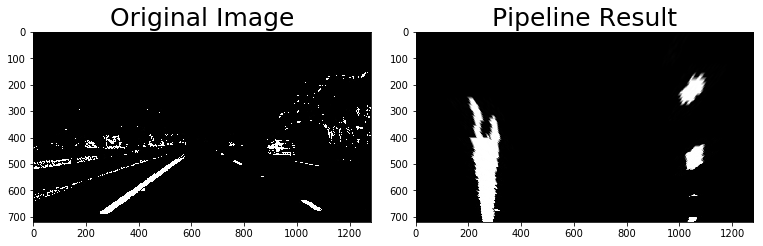

In [509]:
import matplotlib.image as mpimg
# Make a list of test images
file_path = os.getcwd()
file_path = file_path + '/output_images/binary*.jpg'
images = glob.glob(file_path) 

i=0
for fname in images:    
    image = mpimg.imread(fname)
    #image = cv2.erode(image, np.ones((3, 3)))
    #image = cv2.dilate(image, np.ones((3, 3)))


    top_down,M = image_unwarp(image)

    i=i+1
    file_path = os.getcwd()
    file_path = file_path + '/output_images/' + 'warp' + str(i) + '.jpg'
    cv2.imwrite(file_path,top_down)

    # Plot the result
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
    f.tight_layout()

    image = np.array(cv2.merge((image,image,image)),np.uint8)
    ax1.imshow(image)
    ax1.set_title('Original Image', fontsize=25)
    
    top_down = np.array(cv2.merge((top_down,top_down,top_down)),np.uint8)
    ax2.imshow(top_down)
    ax2.set_title('Pipeline Result', fontsize=25)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## Detect lane pixels and fit to find the lane boundary.

In [510]:
def window_mask(width, height, img_ref, center,level):
    output = np.zeros_like(img_ref)
    output[int(img_ref.shape[0]-(level+1)*height):int(img_ref.shape[0]-level*height),max(0,int(center-width/2)):min(int(center+width/2),img_ref.shape[1])] = 1
    return output

In [511]:
def find_window_centroids(warped, window_width, window_height, margin):
    
    window_left_centroids = [] # Store the (left,right) window centroid positions per level
    window_right_centroids = [] # Store the (left,right) window centroid positions per level

    window = np.ones(window_width) # Create our window template that we will use for convolutions
    
    # First find the two starting positions for the left and right lane by using np.sum to get the vertical image slice
    # and then np.convolve the vertical image slice with the window template 
    
    # Sum quarter bottom of image to get slice, could use a different ratio
    l_sum = np.sum(warped[int(3*warped.shape[0]/4):,:int(warped.shape[1]/2)], axis=0)
    l_center = np.argmax(np.convolve(window,l_sum))-window_width/2
    r_sum = np.sum(warped[int(3*warped.shape[0]/4):,int(warped.shape[1]/2):], axis=0)
    r_center = np.argmax(np.convolve(window,r_sum))-window_width/2+int(warped.shape[1]/2)
    
    # Add what we found for the first layer
    window_left_centroids.append(l_center)
    window_right_centroids.append(r_center)

    # Go through each layer looking for max pixel locations
    for level in range(1,(int)(warped.shape[0]/window_height)):
        # convolve the window into the vertical slice of the image
        image_layer = np.sum(warped[int(warped.shape[0]-(level+1)*window_height):int(warped.shape[0]-level*window_height),:], axis=0)
        conv_signal = np.convolve(window, image_layer)
        # Find the best left centroid by using past left center as a reference
        # Use window_width/2 as offset because convolution signal reference is at right side of window, not center of window
        offset = window_width/2
        l_min_index = int(max(l_center+offset-margin,0))
        l_max_index = int(min(l_center+offset+margin,warped.shape[1]))
        l_center = np.argmax(conv_signal[l_min_index:l_max_index])+l_min_index-offset
        if (max(conv_signal[l_min_index:l_max_index])>1000):
            window_left_centroids.append(l_center)
 
        # Find the best right centroid by using past right center as a reference
        r_min_index = int(max(r_center+offset-margin,0))
        r_max_index = int(min(r_center+offset+margin,warped.shape[1]))
        r_center = np.argmax(conv_signal[r_min_index:r_max_index])+r_min_index-offset
        if (max(conv_signal[r_min_index:r_max_index])>1000):
            window_right_centroids.append(r_center)
        # Add what we found for that layer
    return window_left_centroids,window_right_centroids

In [527]:
def detect_lanes(binary_warped,n_filter):
    global global_left_fitx
    global global_right_fitx
    global global_left_fit_cr
    global global_right_fit_cr

    # Assuming you have created a warped binary image called "binary_warped"
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]/2:,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    
    global_left_fitx.append(left_fit)
    global_left_fitx = global_left_fitx[-n_filter:]
    left_fit = np.median(np.array(global_left_fitx), axis=0)

    global_right_fitx.append(right_fit)
    global_right_fitx = global_right_fitx[-n_filter:]
    right_fit = np.median(np.array(global_right_fitx), axis=0) 
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/850 # meters per pixel in x dimension
      

    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    
    global_left_fit_cr.append(left_fit_cr)
    global_left_fit_cr = global_left_fit_cr[-n_filter:]
    left_fit_cr = np.median(np.array(global_left_fit_cr), axis=0)
    
    global_right_fit_cr.append(right_fit_cr)
    global_right_fit_cr = global_right_fit_cr[-n_filter:]
    right_fit_cr = np.median(np.array(global_right_fit_cr), axis=0)
    
    # Calculate the new radi of curvature
    y_eval = np.max(ploty)
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    
    # Now our radius of curvature is in meter
    left_c = left_fit[0]*y_eval**2 + left_fit[1]*y_eval + left_fit[2]
    right_c = right_fit[0]*y_eval**2 + right_fit[1]*y_eval + right_fit[2]

    center_dist = (right_c-left_c)/2 + left_c
    center_dist = (binary_warped.shape[1]/ 2 - center_dist)*xm_per_pix
    
    return out_img,ploty,left_fitx,right_fitx,left_curverad,right_curverad,center_dist

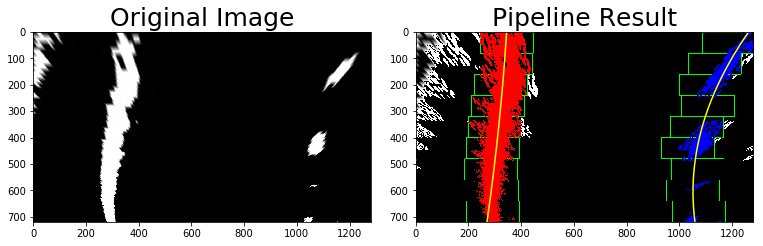

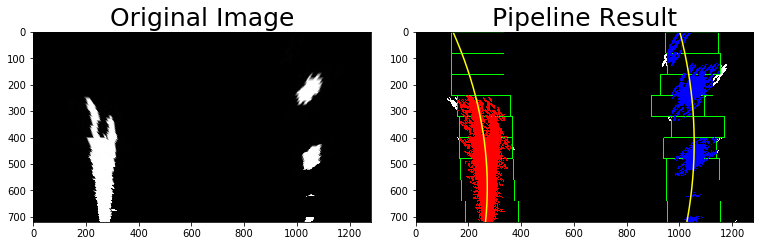

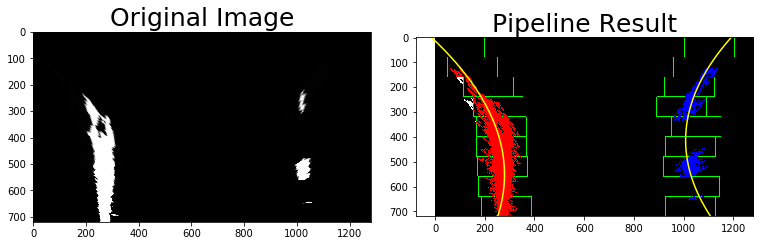

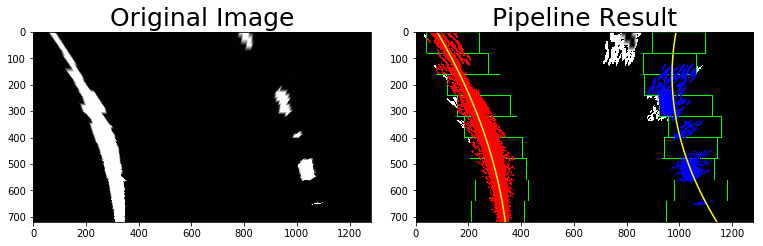

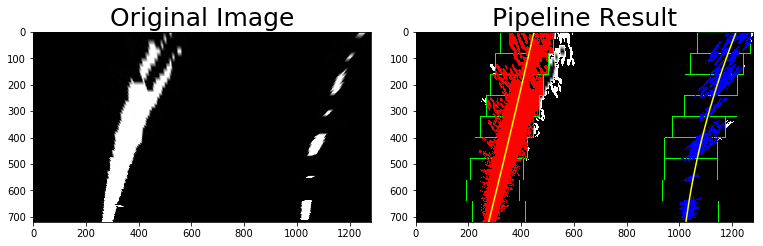

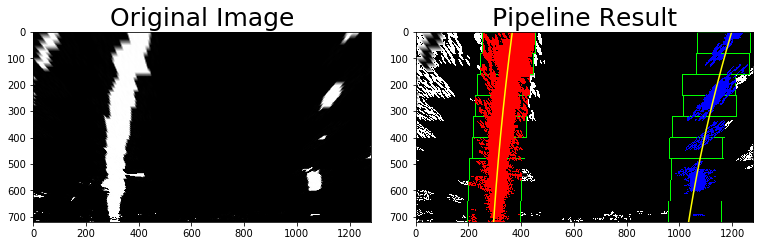

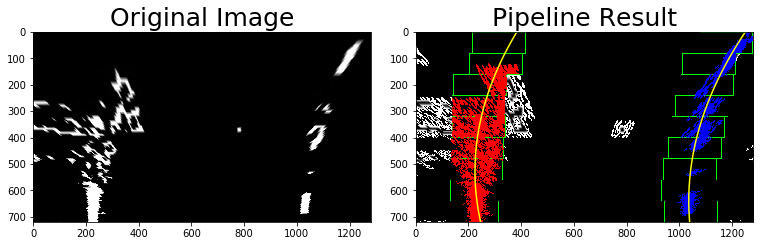

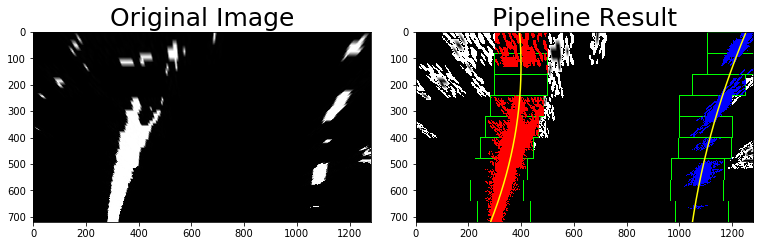

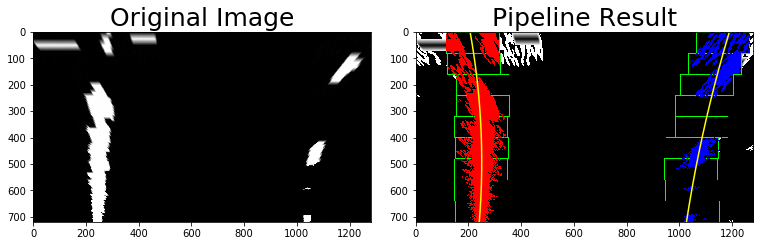

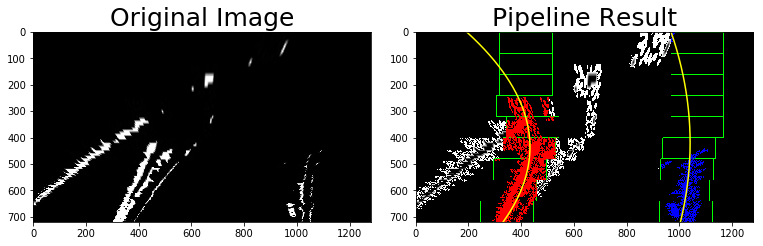

In [528]:
import matplotlib.image as mpimg

# Make a list of test images
file_path = os.getcwd()
file_path = file_path + '/output_images/warp*.jpg'
images = glob.glob(file_path) 

i=0
for fname in images:    
    image = mpimg.imread(fname)
    global_left_fitx = []
    global_right_fitx = []
    global_left_fit_cr = []
    global_right_fit_cr = []
    output,ploty,left_fitx,right_fitx,left_curverad,right_curverad,center_dist = detect_lanes(image,1)

    i=i+1
    file_path = os.getcwd()
    file_path = file_path + '/output_images/' + 'detect' + str(i) + '.jpg'
    cv2.imwrite(file_path,output)

    # Plot the result
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
    f.tight_layout()

    image = np.array(cv2.merge((image,image,image)),np.uint8)
    ax1.imshow(image)
    ax1.set_title('Original Image', fontsize=25)

    ax2.imshow(output)
    ax2.set_title('Pipeline Result', fontsize=25)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    ''' 
    plt.imshow(out_img)
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    plt.xlim(0, 1280)
    plt.ylim(720, 0)
    ''' 

## Determine the curvature of the lane and vehicle position with respect to center.

In [530]:
def measure(output,left_curverad,right_curverad,center_dist):   
    font = cv2.FONT_HERSHEY_SIMPLEX
    textl = str(int(left_curverad)) + 'm'
    textr = str(int(right_curverad)) + 'm'
    textc = str(int(center_dist*100)) + 'cm'

    output = cv2.putText(output,textl,(10,80), font, 2,(255,255,255),2,cv2.LINE_AA)
    output = cv2.putText(output,textr,(1050,80), font, 2,(255,255,255),2,cv2.LINE_AA)
    output = cv2.putText(output,textc,(550,80), font, 2,(255,255,255),2,cv2.LINE_AA)

    return output

## Warp the detected lane boundaries back onto the original image.

In [515]:
def warp_back(warped,undist,M,ploty,left_fitx,right_fitx):
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, M, (image.shape[1], image.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
    return result

## Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

In [516]:
clip2 = VideoFileClip("project_video.mp4").save_frame('test7.jpg', t=40.5, withmask=True)
clip2 = VideoFileClip("project_video.mp4").save_frame('test8.jpg', t=41.0, withmask=True)
clip2 = VideoFileClip("challenge_video.mp4").save_frame('test9.jpg', t=1, withmask=True)
clip2 = VideoFileClip("challenge_video.mp4").save_frame('test10.jpg', t=3, withmask=True)
clip2 = VideoFileClip("challenge_video.mp4").save_frame('test11.jpg', t=5, withmask=True)
clip2 = VideoFileClip("challenge_video.mp4").save_frame('test12.jpg', t=7, withmask=True)
clip2 = VideoFileClip("challenge_video.mp4").save_frame('test13.jpg', t=9, withmask=True)
clip2 = VideoFileClip("challenge_video.mp4").save_frame('test14.jpg', t=11, withmask=True)

  self.nchannels))



In [517]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [533]:
def process_image(img):
    undist = undistort_image(img, mtx, dist)
    img_binary, img_stack = image_threshold(undist)
    warped,Minv = image_unwarp(img_binary)
    lanes,ploty,left_fitx,right_fitx,left_curverad,right_curverad,center_dist = detect_lanes(warped,20)
    output = warp_back(warped,undist,Minv,ploty,left_fitx,right_fitx)
    output = measure(output,left_curverad,right_curverad,center_dist)   
    return output
    #warped = np.array(cv2.merge((warped,warped,warped)),np.uint8) # making the original road pixels 3 color channels
    #return warped

In [534]:
dist_pickle = pickle.load( open( "calibration_results.p", "rb" ) )
mtx = dist_pickle["mtx"]
dist = dist_pickle["dist"]
global_left_fitx = []
global_right_fitx = []
global_left_fit_cr = []
global_right_fit_cr = []
left_rad = []
right_rad = []
dist_c = []

project_output = 'project_output.mp4'

clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(process_image)#.subclip(0,0.5) #NOTE: this function expects color images!!
%time white_clip.write_videofile(project_output, audio=False)

  self.nchannels))




[MoviePy] >>>> Building video project_output.mp4
[MoviePy] Writing video project_output.mp4


  0%|          | 0/1261 [00:00<?, ?it/s]WARNING:py.warnings:/Users/jiforcen/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/ipykernel/__main__.py:9: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future

100%|█████████▉| 1260/1261 [08:17<00:00,  2.53it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_output.mp4 

CPU times: user 7min 22s, sys: 2min 7s, total: 9min 29s
Wall time: 8min 18s


In [488]:
HTML("""
<video width="500" height="300" controls>
  <source src="{0}">
</video>
""".format(project_output))

In [489]:
def process_image_ex(img):
    undist = undistort_image(img, mtx, dist)
    img_binary, img_stack = image_threshold(undist)
    warped,Minv = image_unwarp(img_binary)
    lanes,ploty,left_fitx,right_fitx,left_curverad,right_curverad,center_dist = detect_lanes(warped,20)
    output = warp_back(warped,undist,Minv,ploty,left_fitx,right_fitx)
    output = measure(output,left_curverad,right_curverad,center_dist)

    output1 = cv2.resize(img_stack,(640, 360), interpolation = cv2.INTER_AREA)
    output2 = cv2.resize(lanes,(640, 360), interpolation = cv2.INTER_AREA)

    # Create an array big enough to hold both images next to each other.
    vis = np.zeros((720, 1280+640, 3))

    # Copy both images into the composite image.
    vis[:720, :1280,:] = output
    vis[:360, 1280:1920,:] = output1
    vis[360:720, 1280:1920,:] = output2
    
    return vis
    #warped = np.array(cv2.merge((warped,warped,warped)),np.uint8) # making the original road pixels 3 color channels
    #return warped

In [490]:
dist_pickle = pickle.load( open( "calibration_results.p", "rb" ) )
mtx = dist_pickle["mtx"]
dist = dist_pickle["dist"]
global_left_fitx = []
global_right_fitx = []
left_rad = []
right_rad = []
dist = []

project_output = 'challenge_output.mp4'
clip1 = VideoFileClip("challenge_video.mp4").subclip(0,9)

#save_frame(filename, t=0, withmask=True)[source]

white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(project_output, audio=False)

  self.nchannels))



TypeError: distCoeffs is not a numpy array, neither a scalar

In [491]:
HTML("""
<video width="500" height="300" controls>
  <source src="{0}">
</video>
""".format(challenge_output))

ERROR:root:An unexpected error occurred while tokenizing input
The following traceback may be corrupted or invalid
The error message is: ('EOF in multi-line string', (1, 0))



NameError: name 'challenge_output' is not defined